In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

print('Libraries Loaded')

Libraries Loaded


In [2]:
## Utilities 

def read_file(path):
    df= pd.read_excel(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being copied from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

In [3]:
## Loading the file 

src = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Data'
filename = r'Pave_data_cleaned.xlsx'

dest = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Solutions'

df = read_file(os.path.join(src,filename))

(10896, 7)
   Year  Month  Day  Hour  Temp  Solar  Pavement
0  2009     11    1     1   8.4    0.0  9.333333
1  2009     11    1     2   8.3    0.0  8.933333
2  2009     11    1     3   7.9    0.0  8.700000
3  2009     11    1     4   7.6    0.0  8.533333
4  2009     11    1     5   6.9    0.0  8.533333


In [4]:
## Training the training and testing data

x_train,x_test,y_train,y_test,scaler = splitter(df[['Temp','Pavement']],['Pavement'],24,6,0.8)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(8716, 2) (2180, 2)
The shape of x_train is (8686, 24, 2) and x_test is (2150, 24, 2)
The shape of y_train is (8686, 6) and y_test is (2150, 6)


## LSTM Model

In [5]:
## Creating the prelimaries 

filepath_simple = 'simple_lstm.hdf5'
filepath_attention = 'attention_lstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [6]:
## Simple LSTM
K.clear_session()
simple_lstm = keras.Sequential()
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Flatten())
simple_lstm.add(keras.layers.Dense(512, activation='relu'))
simple_lstm.add(keras.layers.Dense(128, activation='relu'))
simple_lstm.add(keras.layers.Dense(64, activation='relu'))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.Dense(32))
simple_lstm.add(keras.layers.Dense(6))

simple_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

In [7]:
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

# history = simple_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

# plt.plot(history.history['loss'],'r',label='Training Loss')
# plt.plot(history.history['val_loss'],'b',label='Validation Loss')
# plt.legend()
# plt.show()

simple_lstm.load_weights(filepath_simple)
preds = simple_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


Directory present
The Mean Squared Error is: 5.831630519312005


In [13]:
## Attention model

K.clear_session()
atten_lstm = keras.Sequential()
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
# atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Flatten())
atten_lstm.add(keras.layers.Dense(512, activation='relu'))
atten_lstm.add(keras.layers.Dense(128, activation='relu'))
atten_lstm.add(keras.layers.Dense(64, activation='relu'))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.Dense(32))
atten_lstm.add(keras.layers.Dense(6))

atten_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

Directory present
Epoch 1/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0166 - mae: 0.0919 - val_loss: 0.0046 - val_mae: 0.0550
Epoch 2/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0067 - mae: 0.0614 - val_loss: 0.0032 - val_mae: 0.0446
Epoch 3/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0051 - mae: 0.0530 - val_loss: 0.0018 - val_mae: 0.0335
Epoch 4/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0043 - mae: 0.0485 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 5/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0035 - mae: 0.0434 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 6/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0029 - mae: 0.0384 - val_loss: 0.0012 - val_mae: 0.0278
Epoch 7/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0025 - mae: 0.0359 - val_loss: 8.1998e-04 - val_mae: 0.0230
Epoch 8/200
245/245 [=========================

245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0253 - val_loss: 4.8564e-04 - val_mae: 0.0166
Epoch 61/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 4.5125e-04 - val_mae: 0.0159
Epoch 62/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 5.4331e-04 - val_mae: 0.0177
Epoch 63/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 4.4389e-04 - val_mae: 0.0156
Epoch 64/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0243 - val_loss: 4.8704e-04 - val_mae: 0.0163
Epoch 65/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 4.6202e-04 - val_mae: 0.0157
Epoch 66/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 6.0256e-04 - val_mae: 0.0186
Epoch 67/200
245/245 [=========================

245/245 [==============================] - 2s 7ms/step - loss: 8.9078e-04 - mae: 0.0215 - val_loss: 5.2264e-04 - val_mae: 0.0172
Epoch 119/200
245/245 [==============================] - 2s 7ms/step - loss: 9.0543e-04 - mae: 0.0217 - val_loss: 6.5982e-04 - val_mae: 0.0201
Epoch 120/200
245/245 [==============================] - 2s 7ms/step - loss: 8.9142e-04 - mae: 0.0216 - val_loss: 4.9140e-04 - val_mae: 0.0167
Epoch 121/200
245/245 [==============================] - 2s 7ms/step - loss: 8.7356e-04 - mae: 0.0212 - val_loss: 5.5472e-04 - val_mae: 0.0179
Epoch 122/200
245/245 [==============================] - 2s 7ms/step - loss: 8.9580e-04 - mae: 0.0214 - val_loss: 4.8830e-04 - val_mae: 0.0164
Epoch 123/200
245/245 [==============================] - 2s 7ms/step - loss: 8.9202e-04 - mae: 0.0214 - val_loss: 5.7242e-04 - val_mae: 0.0178
Epoch 124/200
245/245 [==============================] - 2s 7ms/step - loss: 8.8238e-04 - mae: 0.0213 - val_loss: 4.3649e-04 - val_mae: 0.0156
Epoch 125/200

245/245 [==============================] - 2s 7ms/step - loss: 7.8380e-04 - mae: 0.0199 - val_loss: 5.3275e-04 - val_mae: 0.0172
Epoch 176/200
245/245 [==============================] - 2s 7ms/step - loss: 7.9122e-04 - mae: 0.0200 - val_loss: 5.0088e-04 - val_mae: 0.0173
Epoch 177/200
245/245 [==============================] - 2s 7ms/step - loss: 7.8802e-04 - mae: 0.0199 - val_loss: 4.5936e-04 - val_mae: 0.0156
Epoch 178/200
245/245 [==============================] - 2s 7ms/step - loss: 7.8169e-04 - mae: 0.0200 - val_loss: 4.8299e-04 - val_mae: 0.0162
Epoch 179/200
245/245 [==============================] - 2s 7ms/step - loss: 7.7544e-04 - mae: 0.0199 - val_loss: 4.8265e-04 - val_mae: 0.0167
Epoch 180/200
245/245 [==============================] - 2s 7ms/step - loss: 7.6379e-04 - mae: 0.0199 - val_loss: 5.1002e-04 - val_mae: 0.0173
Epoch 181/200
245/245 [==============================] - 2s 7ms/step - loss: 7.8607e-04 - mae: 0.0200 - val_loss: 5.3755e-04 - val_mae: 0.0173
Epoch 182/200

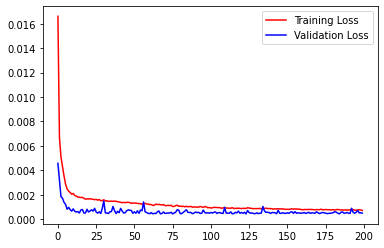

The Mean Squared Error is: 6.021731217632003


In [14]:
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = atten_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_lstm.load_weights(filepath_attention)
preds = atten_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)

wk.save(f'LSTM Result.xls')